# Lets play pool

Today, we will look at image rectification, a common need for a wide range of applications. Here, we will try to undo perspective effects to get a birds-eye view. This is very useful in sport, augmented reality and robotics applications. A similar technique is used to warp sponsor logos to undo unwanted perspective effects from cameras in support of advertising.  

We'll also use today to highlight just how useful the RANSAC technique we taught is.

In [11]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from IPython import display
import random

In [2]:
im = cv2.imread('../test_images/pool.png')[:,:,[2,1,0]]

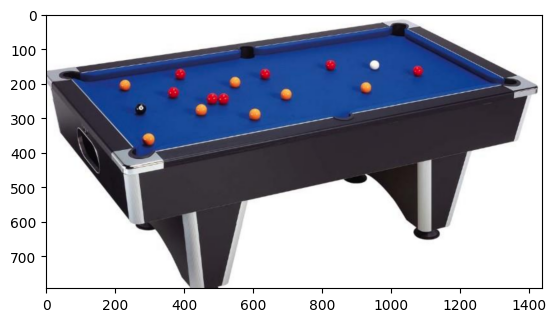

In [3]:
plt.imshow(im)
plt.show()

Let's find the boundaries of the table by segmenting out the blue region and then get some edges.

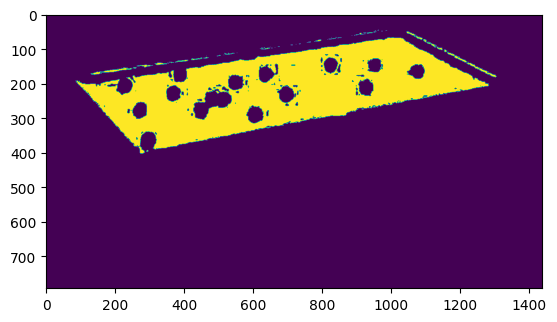

In [4]:
felt = (im[:,:,2]<165)&(im[:,:,2]>135)&(im[:,:,0]<35)
plt.imshow(felt)
plt.show()

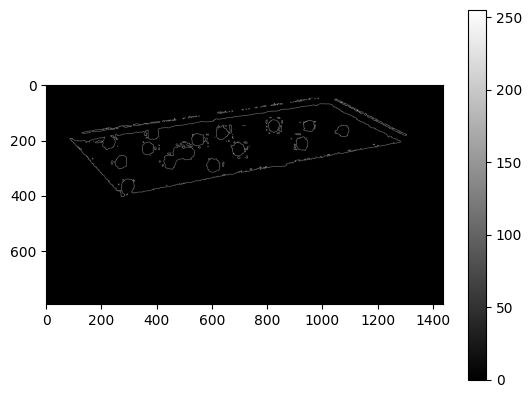

In [5]:
edges = cv2.Canny(felt.astype(np.uint8)*255,100,200)

plt.imshow(edges,cmap = 'gray')
plt.colorbar()
plt.show()

Last week we saw that ransac was a really good way of fitting homographies, by discarding outliers, but this idea can be used to fit any model. Let's use it to fit straight lines to find the edges of the pool table.

We'll extend ransac to return the 4 best lines with sufficient evidence (an edge response), and with an intersection point on the y-axis that differs from others.

Recall that the equation of a line is $ax + by + c = 0$, we can draw two edge points at random, fit a line through these, and then check consensus, repeating until we find all the key lines. We'll use lines and conics to achieve this efficiently. Let's visualise this.

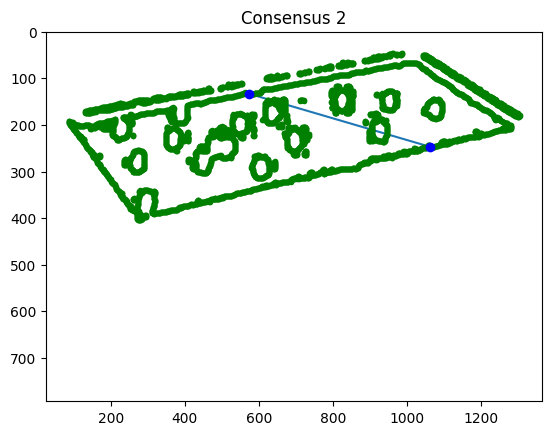

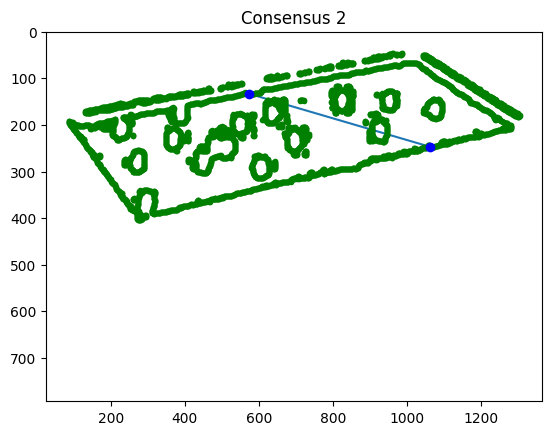

In [7]:
# get all edgels
points_x,points_y = np.where(edges>0)
# convert to homogenous coordinates
points_homog = np.vstack([points_x,points_y,np.ones(len(points_x))]).T

for j in range(20):
    
    # Pick two points at random
    bins = np.random.choice(len(points_x),2,replace=False)

    # find the line intersecting these using the cross (wedge) product
    line = np.cross(points_homog[bins[0],:],points_homog[bins[1],:])

    # Check how many other points lie within 5 pixels of this using the dot product
    consensus = (np.abs(np.sum(line*points_homog,axis=-1)) < 5)
   
    plt.clf()
    plt.plot(points_homog[bins,1],points_homog[bins,0])
    bins_c = consensus
   
    plt.plot(points_homog[~bins_c,1],points_homog[~bins_c,0],'g.')
    plt.plot(points_homog[bins_c,1],points_homog[bins_c,0],'bo')
    plt.title('Consensus %d'%np.sum(consensus))
    plt.ylim(edges.shape[0],0)
            
    display.clear_output(wait=True)
    display.display(plt.gcf())

Cool, let's turn this into a function to find the boundaries

In [8]:
def ransac_line(image,N=1000,max_error=5, existing_line_threshold=5):
    
    good_lines = []
    consensus_list = []
    
    points_x,points_y = np.where(edges>0)
    points_homog = np.vstack([points_x,points_y,np.ones(len(points_x))]).T
    
    for j in range(N):

        bins = np.random.choice(len(points_x),2,replace=False)

        line = np.cross(points_homog[bins[0],:],points_homog[bins[1],:])
        
        line = line/np.sqrt(line[0]**2 + line[1]**2)
        
        line = line.reshape(1,3)

        consensus = np.sum((np.abs(np.sum(line*points_homog,axis=-1)) <= max_error))
        
        if len(good_lines) > 0:


            # Check if line already found by comparing intercepts
            c_good = -np.vstack(good_lines)[:,2]/(np.vstack(good_lines)[:,0]+1e-19)
            c_line = -line[0,2]/(line[0,0]+1e-19)  

            d = np.abs(c_good-c_line)
            best_d = np.argmin(d)

            # Check if line alread exists 
            if (np.min(d) < existing_line_threshold):
                #if better than current consensus, replace line
                if (np.sum(d<existing_line_threshold)==1)&(consensus > consensus_list[best_d]): # existing line
                    good_lines[best_d] = line
                    consensus_list[best_d] = consensus
                    
            else:
                # less than 4 lines - add a new one
                if len(good_lines) < 4:
                    good_lines.append(line)
                    consensus_list.append(consensus)    
                # more than four lines, replace if better than worst line consensus
                elif (consensus > np.min(np.array(consensus_list))):
                    worst_consensus = np.argmin(np.array(consensus_list))
                    good_lines[worst_consensus] = line
                    consensus_list[worst_consensus] = consensus
            
        else:
            good_lines.append(line)
            consensus_list.append(consensus)

        # Some plotting
        if (j %100==0):
            plt.clf()
            plt.title(consensus_list)
            plt.imshow(edges,cmap = 'gray')
            x = np.linspace(0,edges.shape[0]-1,edges.shape[0],dtype=int)
            for l in good_lines:
                l = l.ravel()
                #ax + by + c = 0 y = -ax/b -c/b
                m = -l[0]/(l[1]+1e-19)
                c = -l[2]/(l[1]+1e-19)    
                
                plt.plot(m*x + c,x)
            m = -line[0,0]/(line[0,1]+1e-19)
            c = -line[0,2]/(line[0,1]+1e-19)    
            plt.plot(m*x + c,x)

            plt.xlim(0,edges.shape[1])
            plt.ylim(edges.shape[0],0)
            display.clear_output(wait=True)
            display.display(plt.gcf())

        

    return good_lines, consensus_list

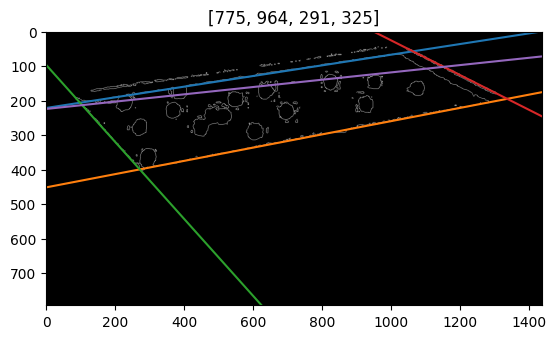

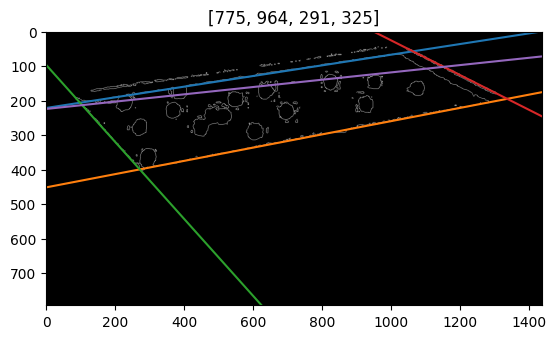

In [9]:
plt.imshow(edges,cmap = 'gray')

lines,consensus_list = ransac_line(edges,N=5000,max_error=2,existing_line_threshold=100)

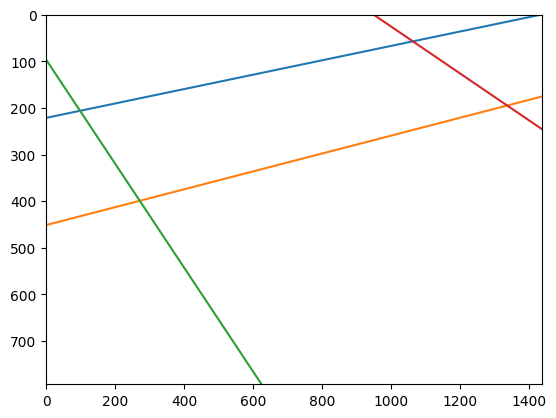

In [10]:
x = np.linspace(0,edges.shape[0]-1,edges.shape[0],dtype=int)
for l in lines:
    l = l.ravel()
    #ax + by + c = 0 y = -ax/b -c/b
    m = -l[0]/(l[1]+1e-19)
    c = -l[2]/(l[1]+1e-19)    
    plt.plot(m*x + c,x)

plt.xlim(0,edges.shape[1])
plt.ylim(edges.shape[0],0)
plt.show()

### Activity 1

- Write pseudocode to find all the circles in the image using a ransac-like approach.

Now lets find the corners, by getting the intercepts using the cross product

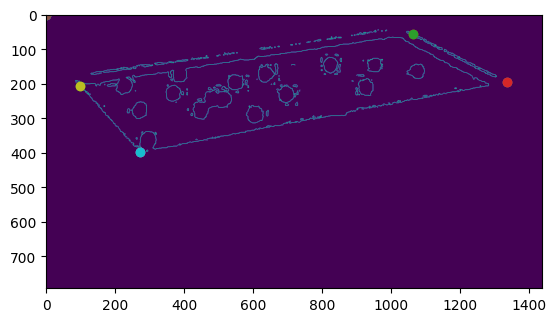

In [13]:
intercepts = []
plt.imshow(edges)
for l1 in lines:
    for l2 in lines:
        
        point = np.cross(l1,l2)
        point = point/(point[0,2]+1e-19)
        plt.plot(point[0,1],point[0,0],'o')
        
        if (point[0,0]>0)&(point[0,1]>0)&(point[0,0]<edges.shape[0])&(point[0,1]<edges.shape[1]):
            intercepts.append(point)
        
plt.xlim(0,edges.shape[1])
plt.ylim(edges.shape[0],0)
plt.show()

intercepts = np.unique(np.vstack((intercepts)),axis=0)
intercepts = intercepts[np.argsort(intercepts[:,0]),:]

To rectify this image, I want to warp it so that the points I've detected move to the 4 corners of the image, as plotted below. We'll do this by solving for the homography

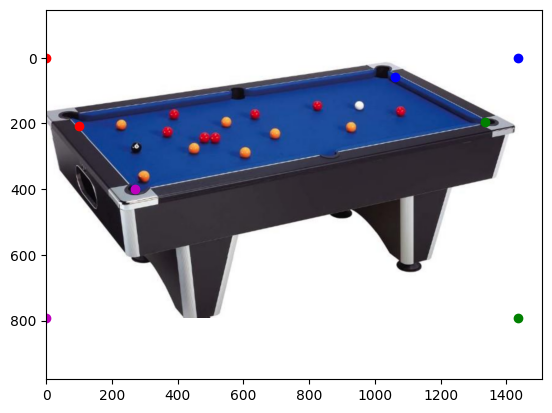

In [14]:
image_corners = np.array([[0,edges.shape[1]],
                          [edges.shape[0],edges.shape[1]],
                          [0,0],
                         [edges.shape[0],0]])

#Sanity check on correspondences
colour_list = ['b','g','r','m']
plt.imshow(im)
for i in range(4):
    plt.plot(intercepts[i,1],intercepts[i,0],'o',color=colour_list[i])
    plt.plot(image_corners[i,1],image_corners[i,0],'o',color=colour_list[i])
plt.axis('equal')
plt.show()

In [18]:
H,_ = cv2.findHomography(intercepts[:,[1,0]],image_corners[:,[1,0]],method=0) 
print(H)

[[ 1.34226535e+00 -1.20280913e+00  1.16027488e+02]
 [ 7.93691382e-01  5.13810745e+00 -1.13761040e+03]
 [-3.46727848e-05  1.08642708e-03  1.00000000e+00]]


The homography maps intercepts onto image corners, using the transform

$\begin{bmatrix}u'\\v'\\1 \end{bmatrix} = \mathbf{H} \begin{bmatrix}u\\v\\1 \end{bmatrix}$

Applying this to all pixels rectifies our image. We can now do all sorts of future steps, eg. build a best shot predictor by detecting ball colours and assessing complexity using angles to pockets.

[[[ 31  66 147]
  [ 26  63 145]
  [ 19  59 142]
  ...
  [ 22  62 141]
  [ 22  62 141]
  [ 23  62 141]]

 [[ 31  66 146]
  [ 26  63 145]
  [ 19  59 142]
  ...
  [ 22  62 141]
  [ 22  62 141]
  [ 23  62 141]]

 [[ 31  66 146]
  [ 26  63 145]
  [ 19  59 142]
  ...
  [ 22  63 142]
  [ 22  63 141]
  [ 23  63 141]]

 ...

 [[ 27  56 133]
  [ 26  57 136]
  [ 24  59 139]
  ...
  [ 19  18  27]
  [ 20  18  26]
  [ 20  18  25]]

 [[ 26  56 134]
  [ 25  57 136]
  [ 24  59 140]
  ...
  [ 20  18  26]
  [ 20  18  25]
  [ 20  18  25]]

 [[ 26  56 134]
  [ 24  57 137]
  [ 23  59 141]
  ...
  [ 20  18  26]
  [ 20  18  25]
  [ 20  18  25]]]


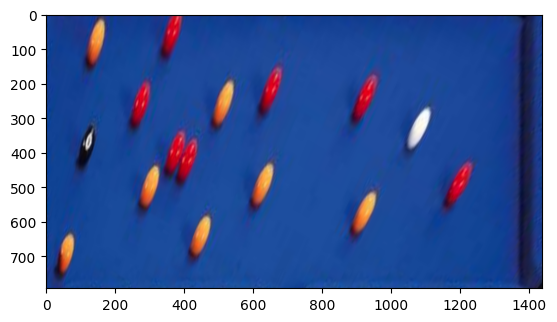

In [19]:
rectified_image = cv2.warpPerspective(im,H,(edges.shape[1],edges.shape[0]))
print(rectified_image)
plt.imshow(rectified_image,cmap='gray')
plt.show()


### Activity 2

- Convince yourself that lines are transformed using the equation $l' = \mathbf{H}^{-\text{T}} l$ 
- The code below applies the homography to lines. Why do lines with near zero elements indicate?
- Why is $ax+by+c =0$ a better representation of a line than $y=mx+c$?

In [ ]:
# Convince yourself that lines are transformed using the equation $l' = \mathbf{H}^{-\text{T}} l$ 



Line 1: 
  [ 3.82795826e-08  5.19904742e+00 -8.14479490e-06]
Line 2: 
  [-8.50124039e-09 -4.35469923e+00  3.45327652e+03]
Line 3: 
  [-1.80233909e+00  2.39820875e-08 -8.24784544e-06]
Line 4: 
  [ 3.09477601e+00 -9.89013746e-08 -4.44719310e+03]


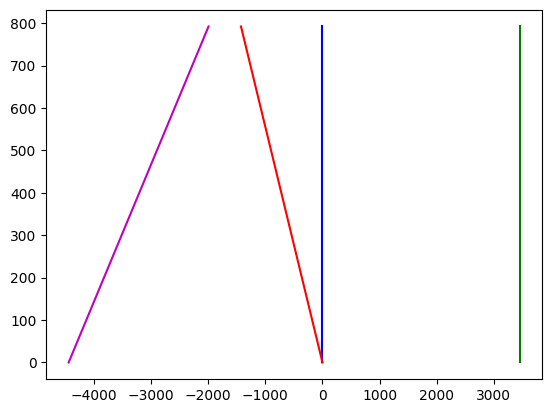

In [21]:
x = np.linspace(0,edges.shape[0]-1,edges.shape[0],dtype=int)

for i, l in enumerate(lines):
    lp = (np.linalg.inv(H).T)@l[:,[1,0,2]].T
    
    lp = lp/(lp[0]**2+lp[1]**2)
    
    print('Line %d: \n '%(i+1), lp.ravel())
    plt.plot(lp[0]*x + lp[2],x,color=colour_list[i])
    
    

### Wrap up:

Some take home messages. 

- Images and objects in these have geometric properties that impose a range of constraints (eg. Lines, circles).
- Camera's are ANGLE and intensity sensors, and subject to perspective geometry effects.
- We can use these constraints to aid in various detection strategies
- This is quite useful in a range of applications, particularly when you have a lot of prior knowledge about the problem (eg. sport, many industrial production lines).
- BUT, these approaches are difficult to tune, and require MANY hand-tuned thresholds
- As a result, it's quite easy to make these work on one image, only to find them fail on another
- Data-driven approaches (like neural networks) and systematic testing strategies can avoid this.
- Incorporating these geometric constraints into data-driven techniques is an active area of research in computer vision